In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animal-faces:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F667852%2F1176357%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240919%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240919T105915Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1dce8988e88e5d4811427fa565706023a209906cb3245810d3ccca16c340920d0f2f18b3b977fb7a55d21f83d5cea73757f98a71b702d2d669606f1ce69dbb55add30ec286dc7fda243d6a52784434d3e8b4252fbb4dc004fe3ade2ee0621a5bb0c5b676ff978bbb1cf960827b4976dbfdd8ba274991b8e9be2956a655cd13d5c3ed07cc755f9c48d4f736e8f58d70b4b7631d77c56838a15e578df76084f4040095ed94a6f9d9881a643e9c8bd57028f168d05a35b49efd8bc5fc330943831f6b693b30d472db4683440c3e37e30bc82e5d7b7490ec6afef9a69af5756f87d889e6c38841ccd52d1a99acddb7e2b8c7de54bcff090ed309f82ade8acccdc4a4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# **Installs**

In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.9 MB/s eta 0:00:0000:010:01


# **Imports**

In [ ]:
# Basic Libraries
import enum
import numpy as np
import matplotlib.pyplot as plt

# PyTorch and TorchVision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models

# PIL and Image Processing
from PIL import Image
from skimage.transform import resize
from skimage.metrics import structural_similarity, mean_squared_error, peak_signal_noise_ratio

# Keras for Image Preprocessing
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

# Captum for Model Interpretability
from captum.attr import IntegratedGradients, Saliency


from collections import defaultdict

import matplotlib.pyplot as plt
from torch import nn

# **Utills**

In [ ]:
class LRPRule(enum.Enum):
    z_plus = 0
    z_b = 1
    alpha_beta = 2
    alpha_beta_bias = 3


class ExplainingMethod(enum.Enum):
    lrp = 0
    gradient = 1
    guided_backprop = 2
    integrated_grad = 3
    pattern_attribution = 4
    grad_times_input = 5

# **Model**

In [ ]:
# Define the PyTorch Model class with ResNet50
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = models.resnet50(weights='DEFAULT')  # Use 'weights' instead of 'pretrained'
        self.model.eval()
        self.input_size = (224, 224)

    def forward(self, x):
        return self.model(x)

    def classify(self, x):
        with torch.no_grad():
            preds = self.forward(x)
            class_idx = torch.argmax(preds, dim=1)
        return preds, class_idx

# **RISE**

In [ ]:
# Generate RISE masks
def generate_masks(N, s, p1, input_size):
    cell_size = np.ceil(np.array(input_size) / s).astype(int)
    up_size = (s + 1) * cell_size
    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')
    masks = np.empty((N, *input_size))
    for i in range(N):
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        resized_mask = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)
        masks[i, :, :] = resized_mask[x:x + input_size[0], y:y + input_size[1]]
    masks = masks.reshape(-1, *input_size, 1)
    return masks

# Apply RISE for saliency maps
def explain(model, inp, masks, N, batch_size, p1):
    model.eval()
    preds = []
    inp = torch.tensor(np.copy(inp), dtype=torch.float32).to(device)
    masks = torch.tensor(np.copy(masks), dtype=torch.float32).to(device)
    masked = inp * masks
    with torch.no_grad():
        for i in range(0, N, batch_size):
            batch = masked[i:min(i + batch_size, N)]
            batch = batch.permute(0, 3, 1, 2)  # Convert from (B, H, W, C) to (B, C, H, W)
            preds_batch = model(batch).cpu().numpy()
            preds.append(preds_batch)
    preds = np.concatenate(preds)
    masks_np = masks.cpu().numpy()
    sal = preds.T.dot(masks_np.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N / p1

    # If `sal` has more than one channel or dimension, average over them
    if sal.ndim == 4:  # Check if the saliency map has more than one channel
        sal = np.mean(sal, axis=0)  # Average across channels or samples
    elif sal.ndim == 3:
        sal = np.mean(sal, axis=0)  # Average if saliency maps are stacked

    return sal




# **Image Loading and Preprocessing**

In [ ]:
# Load and preprocess image
def load_img(path, model):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Main script
# Initialize model
model = Model().to(device)

# Load image and preprocess
img, x = load_img('/kaggle/input/animal-faces/afhq/val/wild/flickr_wild_000038.jpg', model)



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s] 


# **Plotting saliency map**

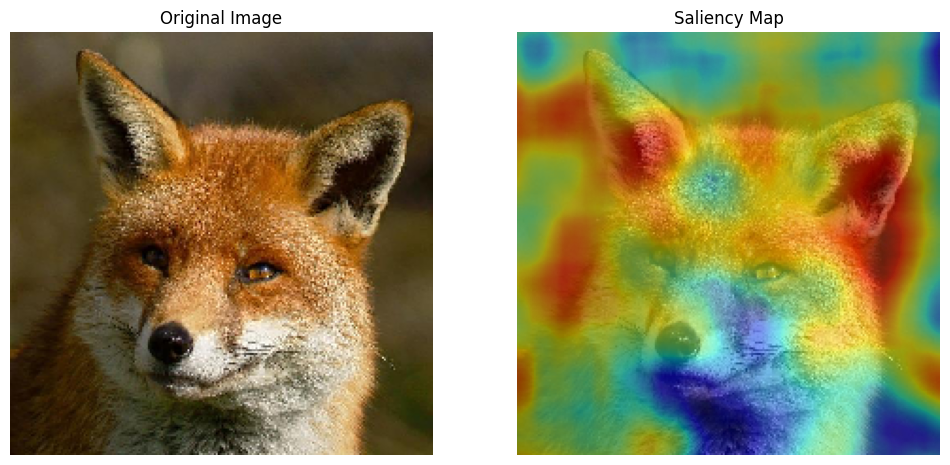

In [ ]:
# Generate RISE masks
masks = generate_masks(2000, 8, 0.5, model.input_size)

# Apply RISE for saliency maps
sal = explain(model, x, masks, 2000, 32, 0.5)

# Convert saliency map to correct format for display
sal = np.squeeze(sal)  # Remove single-dimensional entries from the shape

# Ensure sal is within the range [0, 1] for display
sal = np.clip(sal, 0, 1)

# Plotting
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Saliency Map
plt.subplot(1, 2, 2)
plt.imshow(img)  # Display original image as background
plt.imshow(sal, cmap='jet', alpha=0.5)  # Overlay saliency map
plt.title('Saliency Map')
plt.axis('off')

plt.show()

In [ ]:
def get_center_attack_matrix(x, y, r, org_expl, L):
    """
    Generates a center attack matrix based on the explanation map.

    Parameters:
        x (int): x-coordinate of the center.
        y (int): y-coordinate of the center.
        r (int): Radius for the attack.
        org_expl (torch.Tensor): Explanation map.
        L (int): Size of the matrix.

    Returns:
        np.ndarray: Attack matrix.
    """
    exp_list = org_expl.flatten().cpu().numpy()  # Convert to numpy for processing
    exp_list_sort_idx = np.argsort(exp_list)[::-1]  # Indices of sorted explanations
    exp_list_sort = exp_list[exp_list_sort_idx]  # Sorted explanations
    mtx = np.zeros((L, L))

    # Initialize dictionaries
    counter_dict = defaultdict(int)
    counter_dict_sum = defaultdict(int)

    # Compute distance-based counts
    for i in range(L):
        for j in range(L):
            n1 = np.abs(i - x + 1) + np.abs(j - y + 1)
            counter_dict[n1] += 1

    # Compute cumulative counts
    max_n1 = max(x - 1 + y - 1, y + L - x - 1, L - x + L - y, L - y - 1 + x)
    for i in range(max_n1):
        if i == 0:
            counter_dict_sum[i] = 1
        else:
            counter_dict_sum[i] = counter_dict[i] + counter_dict_sum[i - 1]

    # Fill the matrix
    for i in range(L):
        for j in range(L):
            n1 = np.abs(i - x + 1) + np.abs(j - y + 1)
            idx = counter_dict_sum.get(n1 - 1, 0)
            if idx >= len(exp_list_sort):
                idx = len(exp_list_sort) - 1  # Cap index to the maximum available index

            if n1 == 0:
                mtx[i, j] = exp_list_sort[0]
            elif n1 == 1:
                mtx[i, j] = exp_list_sort[1]
            elif n1 < r:
                mtx[i, j] = exp_list_sort[idx]
            else:
                mtx[i, j] = -exp_list_sort[min(len(exp_list_sort) - 1, counter_dict_sum.get(max_n1 + 1, 0))]

    return mtx


In [ ]:
#Helper method to get the heatmap using Captum
def get_expl(model, x, method, desired_index=None):
    """
    Helper method to get the heatmap using Captum with a PyTorch model.
    """
    x = x.to(device)  # Ensure x is on the correct device
    x.requires_grad = True

    if method == 'integrated_gradients':
        ig = IntegratedGradients(model)
        if desired_index is None:
            preds = model(x)
            desired_index = preds.argmax().item()
        attributions, delta = ig.attribute(x, target=desired_index, return_convergence_delta=True)
        heatmap = attributions.sum(dim=1).cpu().detach()
    elif method == 'saliency':
        saliency = Saliency(model)
        if desired_index is None:
            preds = model(x)
            desired_index = preds.argmax().item()
        attributions = saliency.attribute(x, target=desired_index)
        heatmap = attributions.sum(dim=1).cpu().detach()
    else:
        raise NotImplementedError(f"Explanation method '{method}' is not implemented")

    heatmap = torch.sum(torch.abs(heatmap), dim=1)
    normalized_heatmap = heatmap / torch.sum(heatmap)

    if 'preds' not in locals():
        preds = model(x)
        desired_index = preds.argmax().item()

    return normalized_heatmap, preds, desired_index

In [ ]:
method = 'integrated_gradients'

def load_image(data_mean, data_std, device, image_path):
    """
    Helper method to load an image into a torch tensor. Includes preprocessing.
    """
    im = Image.open(image_path)
    x = torchvision.transforms.Normalize(mean=data_mean, std=data_std)(
        torchvision.transforms.ToTensor()(
            torchvision.transforms.CenterCrop(224)(
                torchvision.transforms.Resize(256)(im)
            )
        )
    )
    x = x.unsqueeze(0).to(device)
    return x

data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = Model().to(device)

# Correctly load image path
image_path = '/kaggle/input/animal-faces/afhq/val/wild/flickr_wild_000038.jpg'

# Load image and preprocess
x = load_image(data_mean, data_std, device, image_path)

x_adv = x.clone().detach().requires_grad_()
print('x', x.shape, type(x))
print('x range', x.min(), x.max())
print('x_adv', x_adv.shape, type(x_adv))
print('x_adv range', x_adv.min(), x_adv.max())

# Assuming get_expl and get_center_attack_matrix are defined elsewhere
org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()

# Target attack
target_mtx = get_center_attack_matrix(200, 200, 35, org_expl, 224)
target_mtx_torch = torch.tensor(target_mtx)
target_mtx_torch = target_mtx_torch.view(1, 224, 224)
target_mtx_torch = target_mtx_torch.to(device).float()

optimizer = torch.optim.Adam([x_adv], lr=0.001)  # Set a proper learning rate


x torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>
x range tensor(-2.0837, device='cuda:0') tensor(2.2914, device='cuda:0')
x_adv torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>
x_adv range tensor(-2.0837, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.2914, device='cuda:0', grad_fn=<MaxBackward1>)


# **Adversarial attack and Explanation**

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example hyperparameters
lr = 0.0002  # Learning rate for the optimizer
num_iter = 600  # Number of iterations for the adversarial attack
exp_method = 'integrated_gradients'  # Choose between 'integrated_gradients' and 'saliency'

case = '0'
exp_method = 'integrated_gradients' #  choices=['lrp', 'guided_backprop', 'gradient', 'integrated_grad', 'pattern_attribution', 'grad_times_input']
#img = 'tmp_image/'+case+'.jpeg'
img = 'tmp_image/'+case+'.jpeg'
#img = 'temp_result/case_'+case+'.jpeg'

red = 'nn/RED.jpeg'
cuda = True
output_dir = 'temp_result/'
beta_growth = True
prefactors = [1e4, 1e10, 1e-4] # 4 10 -4

# Initialize model
model = Model().to(device)  # Ensure you have your Model class defined

# Example data preparation
def preprocess_input(x_np):
    x_np = np.transpose(x_np, (0, 3, 1, 2))  # Convert to [batch_size, channels, height, width]
    x_tensor = torch.tensor(x_np, dtype=torch.float32).to(device)
    return x_tensor

# Create a dummy input tensor
x_np = np.random.rand(1, 224, 224, 3)  # Single RGB image
x_tensor = preprocess_input(x_np)

# Ensure x_tensor has gradients enabled
x_adv = x_tensor.clone().detach().requires_grad_(True)

# Get the original explanation and index
org_expl, org_acc, org_idx = get_expl(model, x_tensor, exp_method)
org_idx = org_idx  # Directly use the index

# Define target matrix and prefactors for loss computation
target_mtx_torch = torch.zeros_like(org_expl, requires_grad=False)  # Example, adjust according to your use case
prefactors = [.5, .5]  # Example, adjust according to your use case
prediction_class = org_idx


In [ ]:
from torchvision import transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the image path
image_path = '/kaggle/input/animal-faces/afhq/val/wild/flickr_wild_000038.jpg'

# Load and preprocess the image
image = Image.open(image_path).convert('RGB')

# Define the preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the model
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
])

# Apply transformations to the image
img_tensor = preprocess(image)

# Add a batch dimension
img_tensor = img_tensor.unsqueeze(0)

# Move to device
img_tensor = img_tensor.to(device)

# Ensure the model is on the same device as the input tensor
model = model.to(device)

# Make predictions
predictions = model(img_tensor)
predictions = predictions.cpu().detach().numpy()
prediction_class = np.argmax(predictions[0])

print("Prediction class: " + str(prediction_class))  # Should print the class index
origin_prediction_class = prediction_class

# Convert the image to a numpy array for further processing
im2 = np.array(image)
im2 = im2.astype(np.float64)
im_orig = im2  # Now im_orig has the shape (224, 224, 3)
print('im2.shape:', im2.shape)

# Further processing
im = im_orig.astype(np.float32)
print('im:', im.shape, type(im))  # Should print the shape of the image, e.g., (224, 224, 3)
print('ori_image')

# Sorting the prediction values
value_sort = np.sort(predictions[0])[::-1]
print(value_sort[:2][0], value_sort[:2][1])
score_diff = value_sort[:2][0] - value_sort[:2][1]
print('dump score diff:', score_diff)


Prediction class: 277
im2.shape: (512, 512, 3)
im: (512, 512, 3) <class 'numpy.ndarray'>
ori_image
6.6510744 5.000115
dump score diff: 1.6509595


In [ ]:
preprocess_1 = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the model
    transforms.ToTensor(),          # Convert image to tensor
])

#without normalization
img_tensor_1 = preprocess_1(image)
# Move to device (GPU or CPU)
img_tensor_1 = img_tensor_1.to(device)

img_tensor_1 = img_tensor_1.unsqueeze(0)

In [ ]:
value_sort = np.sort(predictions[0])[::-1]
index_sort = np.argsort(predictions[0])[::-1]
for i in range(5):
    print('label: ',index_sort[:5][i], ' score: ',value_sort[:5][i])

label:  277  score:  6.6510744
label:  278  score:  5.000115
label:  280  score:  3.9055815
label:  274  score:  2.2495508
label:  273  score:  1.575382


In [ ]:
# # Tracking variables for metrics
# total_loss_list = []
# epoch_exp = []
# L1_score = []
# L2_score = []
# L3_score = []
# L4_score = []
# L5_score = []

# early_stop_epoch = 0
# mode_2_loss = False
# EARLY_STOP = True  # Early stopping flag
# beta_growth = False  # Flag for dynamic beta adjustment, if applicable

# # Ensure x_adv is correctly set to require gradients
# x_adv = x_tensor.clone().detach().requires_grad_(True)

# # Perform adversarial attack
# for i in range(num_iter):
#     optimizer.zero_grad()  # Zero the gradients before the backward pass

#     # Compute the explanation and predictions for the adversarial example
#     adv_expl, adv_acc, class_idx = get_expl(model, x_adv, exp_method, desired_index=org_idx)

#     # Compute the losses
#     loss_center = F.mse_loss(adv_expl, target_mtx_torch)
#     loss_output = F.mse_loss(adv_acc[0][prediction_class], org_acc[0][prediction_class])
#     total_loss = prefactors[0] * loss_output + prefactors[1] * loss_center

#     # Ensure gradients for x_adv are being computed
#     if not x_adv.requires_grad:
#         print(f"Iteration {i + 1}: x_adv does not require gradients.")
#     else:
#         total_loss.backward(retain_graph=True)  # Retain the graph if needed

#     # Check if gradients are computed
#     if x_adv.grad is None:
#         print(f"Iteration {i + 1}: No gradients computed for x_adv")
#     else:
#         print(f"Iteration {i + 1}: Gradients computed. Max: {x_adv.grad.max().item():.4f}, Min: {x_adv.grad.min().item():.4f}")

#     # Update the adversarial example if gradients are computed
#     if x_adv.grad is not None:
#         optimizer.step()  # Apply gradients to update x_adv

#     # Apply clamping to keep the adversarial example within a valid range
#     x_adv.data = clamp(x_adv.data, data_mean, data_std)

#     # Check the range of x_adv and losses
#     print(f"Iteration {i + 1}: Total Loss: {total_loss.item():.4f}, Center Loss: {loss_center.item():.4f}, Output Loss: {loss_output.item():.4f}")
#     print(f"Iteration {i + 1}: x_adv range: min={x_adv.data.min().item():.4f}, max={x_adv.data.max().item():.4f}")

# print("Adversarial attack completed.")



Iteration 1: Total Loss: 2.215696503561027e-08, Center Loss: 2.215696503561027e-05, Output Loss: 0.0
Iteration 50: Total Loss: 3.0593166998396155e-07, Center Loss: 3.7076225409960515e-05, Output Loss: 2.6885543775279075e-05
Iteration 100: Total Loss: 3.8768000163187356e-08, Center Loss: 3.706279762845763e-05, Output Loss: 1.7052025214070454e-07
Iteration 150: Total Loss: 3.7063831315299137e-08, Center Loss: 3.7059627176092235e-05, Output Loss: 4.204139258945361e-10
Iteration 200: Total Loss: 3.7059911649496344e-08, Center Loss: 3.7059800236399984e-05, Output Loss: 1.1141310096718371e-11
Iteration 250: Total Loss: 3.706012537066435e-08, Center Loss: 3.706011627571754e-05, Output Loss: 9.094947017729282e-13
Iteration 300: Total Loss: 3.705897510501731e-08, Center Loss: 3.705897283128061e-05, Output Loss: 2.2737367544323206e-13
Iteration 350: Total Loss: 3.705980844502721e-08, Center Loss: 3.70598061712905e-05, Output Loss: 2.2737367544323206e-13
Iteration 400: Total Loss: 3.7060031397548

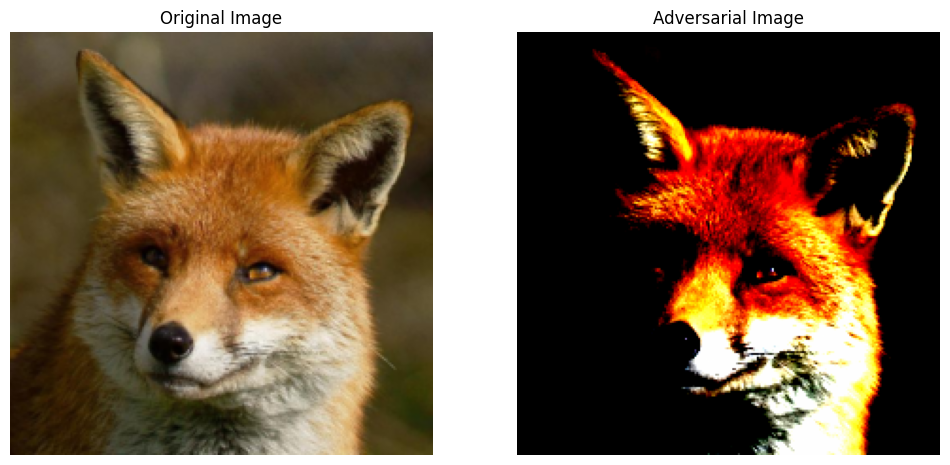

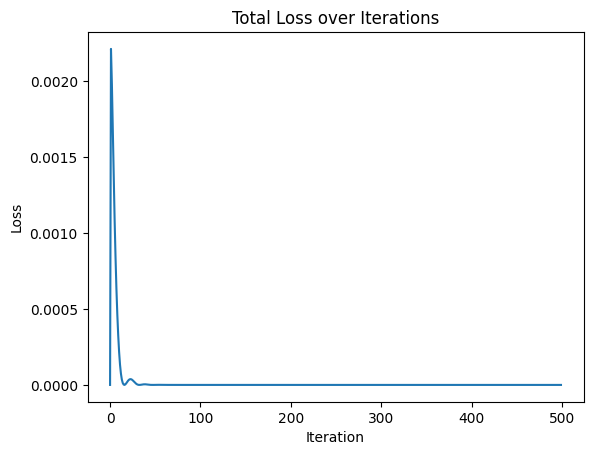

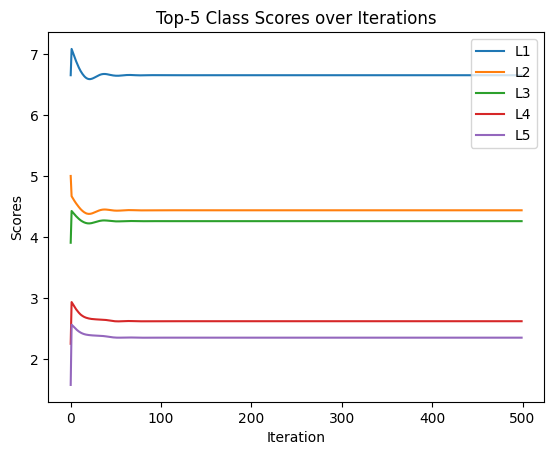

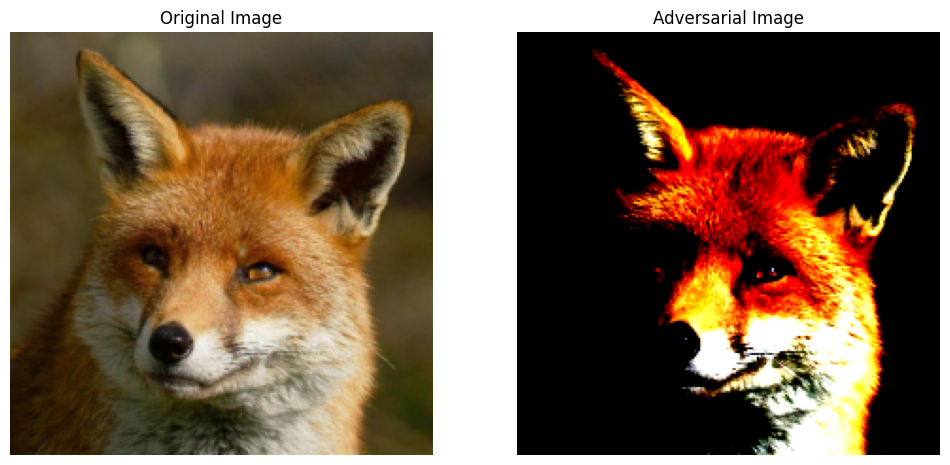

In [ ]:


# Ensure this block has access to all required inputs and methods like `model`, `img_tensor`, `get_expl`, etc.

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_iter = 500  # Number of iterations for the attack
prefactors = [0.01, 0.001]  # Weights for the loss terms
early_stop_epoch = 0
EARLY_STOP = True
learning_rate = 1e-4  # Learning rate for perturbations

# Initialize optimizer
x_adv = img_tensor.clone().detach().to(device).requires_grad_(True)
optimizer = torch.optim.Adam([x_adv], lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

# Instantiate the loss function
mse_loss = nn.MSELoss()

# Store results
total_loss_list = []
L1_score = []
L2_score = []
L3_score = []
L4_score = []
L5_score = []

# Original prediction
output = model(img_tensor)
origin_prediction_class = output.argmax().item()

# Ensure target_mtx_torch and org_acc are defined correctly
target_mtx_torch = torch.zeros_like(img_tensor).to(device)  # Define as needed, should match `adv_expl` shape
org_acc = output.clone().detach()

# Start the adversarial attack loop
for i in range(num_iter):
    optimizer.zero_grad()

    # Calculate loss
    adv_expl, adv_acc, class_idx = get_expl(model, x_adv, method, desired_index=origin_prediction_class)

    # Ensure `adv_expl` and `target_mtx_torch` have matching shapes
    if adv_expl.shape != target_mtx_torch.shape:
        target_mtx_torch = torch.zeros_like(adv_expl)  # Create tensor with the correct shape

    loss_center = mse_loss(adv_expl, target_mtx_torch)
    loss_output = F.mse_loss(adv_acc[0][origin_prediction_class], org_acc[0][origin_prediction_class].detach())

    # Total loss
    total_loss = prefactors[0] * loss_output + prefactors[1] * loss_center
    total_loss_list.append(total_loss.item())

    # Update adversarial example
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    # Obtain new predictions
    predictions = model(x_adv)
    predictions = predictions.cpu().detach().numpy()

    # Update scores for top-5 classes
    index_sort = np.argsort(predictions[0])[::-1]
    L1_score.append(predictions[0][index_sort[0]])
    L2_score.append(predictions[0][index_sort[1]])
    L3_score.append(predictions[0][index_sort[2]])
    L4_score.append(predictions[0][index_sort[3]])
    L5_score.append(predictions[0][index_sort[4]])

    # Early stopping condition
    prediction_class_tmp = np.argmax(predictions[0])
    if i > 10 and origin_prediction_class != prediction_class_tmp:
        print(i, 'early done')
        early_stop_epoch = i
        if EARLY_STOP:
            x_adv = x_adv.clone().detach()
            break

    # Clamp the adversarial example
    x_adv.data = torch.clamp(x_adv.data, 0, 1)  # Ensure valid range [0, 1]

    # Debugging information
    if (i + 1) % 50 == 0 or i == 0:
        print(f"Iteration {i + 1}: Total Loss: {total_loss.item()}, Center Loss: {loss_center.item()}, Output Loss: {loss_output.item()}")
original_image= img
# Visualize results
def plot_images(original_image, adversarial_image):
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Adversarial Image
    plt.subplot(1, 2, 2)
    plt.imshow(adversarial_image)
    plt.title('Adversarial Image')
    plt.axis('off')

    plt.show()

# Convert images to numpy format for plotting
def tensor_to_numpy(tensor):
    tensor = tensor.squeeze().cpu().detach().numpy().transpose(1, 2, 0)  # Convert to HWC format
    return np.clip(tensor, 0, 1)  # Ensure values are within [0, 1]

# Convert tensors to numpy arrays
img_tensor_np = tensor_to_numpy(img_tensor_1)
adversarial_img_np = tensor_to_numpy(x_adv)

# Plot original and adversarial images
plot_images(img_tensor_np, adversarial_img_np)

# Plot the total loss
plt.figure()
plt.plot(total_loss_list)
plt.title('Total Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Plot L1-L5 scores
plt.figure()
plt.plot(L1_score, label='L1')
plt.plot(L2_score, label='L2')
plt.plot(L3_score, label='L3')
plt.plot(L4_score, label='L4')
plt.plot(L5_score, label='L5')
plt.title('Top-5 Class Scores over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Scores')
plt.legend()
plt.show()

def create_adversarial_example(model, img_tensor, epsilon=0.01):
    img_tensor.requires_grad = True

    # Forward pass
    output = model(img_tensor)
    loss = F.cross_entropy(output, torch.tensor([output.argmax()]).to(device))

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Generate adversarial example
    adversarial_img = img_tensor + epsilon * img_tensor.grad.sign()
    adversarial_img = torch.clamp(adversarial_img, 0, 1)  # Keep pixel values between 0 and 1
    return adversarial_img

# Create and visualize adversarial image
adversarial_img = create_adversarial_example(model, img_tensor)
adversarial_img_np = tensor_to_numpy(adversarial_img)
plot_images(img_tensor_np, adversarial_img_np)


In [ ]:
value_sort = np.sort(predictions[0])[::-1]
index_sort = np.argsort(predictions[0])[::-1]
for i in range(5):
    print('label: ',index_sort[:5][i], ' score: ',value_sort[:5][i])

label:  277  score:  6.651074
label:  278  score:  4.437466
label:  280  score:  4.259317
label:  274  score:  2.6193783
label:  273  score:  2.3498282


In [ ]:
target_mtx = torch.zeros_like(org_expl[0])

# Convert saliency maps and target matrix to numpy arrays
adv_expl_np = adv_expl[0].cpu().detach().numpy()
org_expl_np = org_expl[0].cpu().detach().numpy()
target_mtx_flat = target_mtx.flatten()
target_mtx_np = target_mtx_flat.cpu().detach().numpy()  # Ensure target_mtx is also converted to numpy array

# Handle 1D arrays
if len(adv_expl_np.shape) == 1:
    # Reshape target_mtx_np to match other arrays
    target_mtx_np = target_mtx_np.reshape(-1)
elif len(target_mtx_np.shape) == 2:
    # Flatten target_mtx_np if it's 2D with 1 row
    if target_mtx_np.shape[0] == 1:
        target_mtx_np = target_mtx_np.flatten()
    else:
        raise ValueError("Target matrix shape is incompatible for comparison.")

# # Print the shapes to debug
# print("Shape of Original Explanation:", org_expl_np.shape)
# print("Shape of Adversarial Explanation:", adv_expl_np.shape)
# print("Shape of Target Matrix:", target_mtx_np.shape)

# Ensure all matrices have the same dimensions for comparison
if adv_expl_np.shape != org_expl_np.shape or adv_expl_np.shape != target_mtx_np.shape:
    raise ValueError('Input matrices must have the same dimensions.')

# Determine the data range for floating-point images
data_range = adv_expl_np.max() - adv_expl_np.min()  # Assuming the range is the same for all images

# Compare saliency maps
print('SSIM:')
print('Original and Adversarial:', structural_similarity(org_expl_np, adv_expl_np, multichannel=False, data_range=data_range))
print('Original and Target:', structural_similarity(org_expl_np, target_mtx_np, multichannel=False, data_range=data_range))
print('Adversarial and Target:', structural_similarity(adv_expl_np, target_mtx_np, multichannel=False, data_range=data_range))

print('MSE:')
print('Original and Adversarial:', mean_squared_error(org_expl_np, adv_expl_np))
print('Original and Target:', mean_squared_error(org_expl_np, target_mtx_np))
print('Adversarial and Target:', mean_squared_error(adv_expl_np, target_mtx_np))

print('PSNR:')
print('Original and Adversarial:', peak_signal_noise_ratio(org_expl_np, adv_expl_np, data_range=data_range))
print('Original and Target:', peak_signal_noise_ratio(org_expl_np, target_mtx_np, data_range=data_range))
print('Adversarial and Target:', peak_signal_noise_ratio(adv_expl_np, target_mtx_np, data_range=data_range))


SSIM:
Original and Adversarial: 0.12473380470415792
Original and Target: 0.0005653348799339812
Adversarial and Target: 0.2394411722286401
MSE:
Original and Adversarial: 2.3697748656825485e-05
Original and Target: 2.1929184710135065e-05
Adversarial and Target: 3.705958593831519e-05
PSNR:
Original and Adversarial: 8.44617535291728
Original and Target: 8.78302138594224
Adversarial and Target: 6.504240615430794


In [ ]:
org_expl


tensor([[0.0025, 0.0040, 0.0049, 0.0044, 0.0044, 0.0044, 0.0049, 0.0043, 0.0046,
         0.0052, 0.0052, 0.0046, 0.0049, 0.0060, 0.0061, 0.0064, 0.0065, 0.0071,
         0.0074, 0.0074, 0.0072, 0.0065, 0.0078, 0.0075, 0.0069, 0.0076, 0.0092,
         0.0086, 0.0075, 0.0069, 0.0089, 0.0088, 0.0074, 0.0066, 0.0080, 0.0076,
         0.0062, 0.0070, 0.0064, 0.0069, 0.0058, 0.0055, 0.0064, 0.0066, 0.0059,
         0.0056, 0.0047, 0.0058, 0.0057, 0.0050, 0.0064, 0.0062, 0.0057, 0.0054,
         0.0055, 0.0058, 0.0058, 0.0049, 0.0055, 0.0061, 0.0053, 0.0053, 0.0055,
         0.0059, 0.0055, 0.0058, 0.0056, 0.0056, 0.0052, 0.0044, 0.0048, 0.0055,
         0.0047, 0.0041, 0.0045, 0.0050, 0.0040, 0.0042, 0.0046, 0.0049, 0.0047,
         0.0045, 0.0050, 0.0047, 0.0040, 0.0042, 0.0045, 0.0043, 0.0038, 0.0046,
         0.0049, 0.0040, 0.0047, 0.0040, 0.0047, 0.0044, 0.0042, 0.0039, 0.0045,
         0.0048, 0.0040, 0.0041, 0.0043, 0.0042, 0.0033, 0.0037, 0.0036, 0.0038,
         0.0034, 0.0032, 0.0

# **Plotting Adversarial Saliency Map**

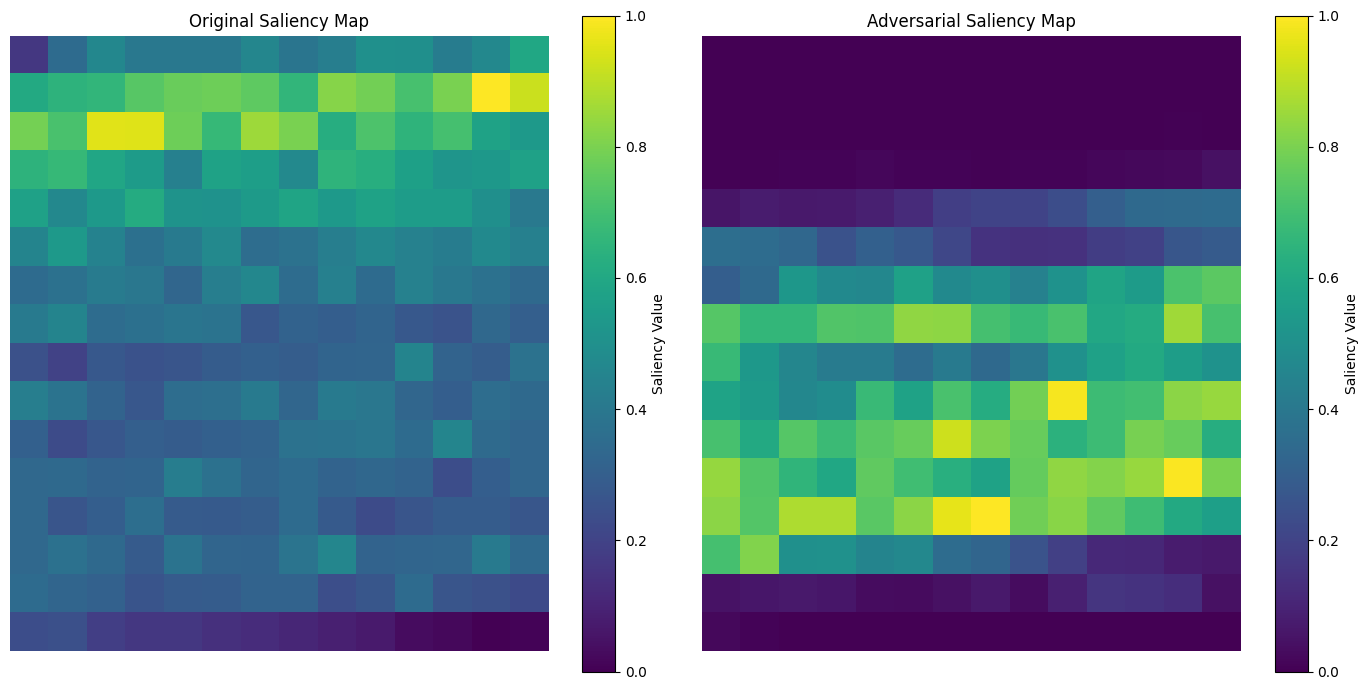

In [ ]:
import torch  # Make sure to import torch
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for plotting
def to_numpy(arr):
    if torch.is_tensor(arr):
        return arr.cpu().detach().numpy()
    return arr  # It's already a NumPy array

# Apply conversion
adv_expl_np = to_numpy(adv_expl[0])
org_expl_np = to_numpy(org_expl[0])

# Reshape to 2D (e.g., (16, 14)) if they are 1D
def reshape_for_display(arr, target_shape=(16, 14)):
    if arr.ndim == 1:
        return arr.reshape(target_shape)
    return arr

# Replace with the appropriate shape if necessary
adv_expl_np = reshape_for_display(adv_expl_np, target_shape=(16, 14))
org_expl_np = reshape_for_display(org_expl_np, target_shape=(16, 14))

# Normalize data (optional, but recommended for saliency maps)
adv_expl_np = (adv_expl_np - adv_expl_np.min()) / (adv_expl_np.max() - adv_expl_np.min())
org_expl_np = (org_expl_np - org_expl_np.min()) / (org_expl_np.max() - org_expl_np.min())

# Plot the saliency maps
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot the original saliency map
im1 = axes[0].imshow(org_expl_np, cmap='viridis', interpolation='none', norm=plt.Normalize(vmin=0, vmax=1))
axes[0].set_title('Original Saliency Map')
axes[0].axis('off')
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Saliency Value')

# Plot the adversarial saliency map
im2 = axes[1].imshow(adv_expl_np, cmap='viridis', interpolation='none', norm=plt.Normalize(vmin=0, vmax=1))
axes[1].set_title('Adversarial Saliency Map')
axes[1].axis('off')
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Saliency Value')

plt.tight_layout()
plt.show()
